# Aula 3

---

**Saulo Martiello Mastelini**<br>
Candidato a Ph.D. pelo ICMC-USP<br>
Online Machine Learning

Página pessoal: [smastelini](https://smastelini.github.io/)</br>
e-mail: saulomastelini@gmail.com

---

## Sumário:

- Naive Bayes
- Validação cruzada
- Processamento de texto básico
- Visualização de fronteiras de decisão

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt  # para fazer os gráficos
from sklearn.datasets import make_moons  # gerar os dados sintéticos
from sklearn.datasets import load_wine

Função para visualizar fronteiras de decisão (mais tarde)

In [2]:
# Adaptado de: https://github.com/tirthajyoti/Machine-Learning-with-Python/blob/master/Utilities/ML-Python-utils.py
def plot_decision_boundaries(X, y, model_class, **model_params):
    """Function to plot the decision boundaries of a classification model.

    This uses just the first two columns of the data for fitting 
    the model as we need to find the predicted value for every point in 
    scatter plot.
    Arguments:
            X: Feature data as a NumPy-type array.
            y: Label data as a NumPy-type array.
            model_class: A Scikit-learn ML estimator class 
            e.g. GaussianNB (imported from sklearn.naive_bayes) or
            LogisticRegression (imported from sklearn.linear_model)
            **model_params: Model parameters to be passed on to the ML estimator
    
    Typical code example:
            plt.figure()
            plt.title("KNN decision boundary with neighbros: 5",fontsize=16)
            plot_decision_boundaries(X_train,y_train,KNeighborsClassifier,n_neighbors=5)
            plt.show()
    """
    from matplotlib import colormaps
    import matplotlib.markers as mmarkers
    def mscatter(x, y, ax=None, m=None, **kw):
        if not ax: ax=plt.gca()
        sc = ax.scatter(x,y,**kw)
        if (m is not None) and (len(m)==len(x)):
            paths = []
            for marker in m:
                if isinstance(marker, mmarkers.MarkerStyle):
                    marker_obj = marker
                else:
                    marker_obj = mmarkers.MarkerStyle(marker)
                path = marker_obj.get_path().transformed(
                            marker_obj.get_transform())
                paths.append(path)
            sc.set_paths(paths)
        return sc

    try:
        X = np.array(X)
        y = np.array(y).flatten()
    except:
        print("Coercing input data to NumPy arrays failed")
    
    classes = np.unique(y)

    # Reduces to the first two columns of data
    reduced_data = X[:, :2]
    # Instantiate the model object
    model = model_class(**model_params)
    # Fits the model with the reduced data
    model.fit(reduced_data, y)

    # Step size of the mesh. Decrease to increase the quality of the VQ.
    h = .02     # point in the mesh [x_min, m_max]x[y_min, y_max].    

    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
    y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
    # Meshgrid creation
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Obtain labels for each point in mesh using the model.
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])    

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

    # Predictions to obtain the classification results
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    
    # Right now it only works with binary tasks: expand both dictionaries or use cmap for multiclass tasks

    cmap = colormaps['viridis']

    markers = {0: "o", 1: "^", 2: "s", 3: "D", 4: "+", 5: "*"}

    m = list(map(lambda i: markers[i], y))
    
    # Plotting
    plt.contourf(xx, yy, Z, alpha=0.5, cmap=cmap)
    mscatter(x=X[:, 0], y=X[:, 1], c=y, m=m, cmap=cmap)
    
    plt.xlabel("x1",fontsize=15)
    plt.ylabel("x2",fontsize=15)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    return plt

## 1. Motivação e Naive Bayes

Um pouco de notação:

- **Eventos:** algum fenômeno de interesse.
    - Por exemplo: ônibus atrasar, ganhar uma rifa, ser aprovado em uma disciplina.
- **Evidências:** observações e subsídios que temos para respaldar a probabilidade de algo (um evento) acontencer.
    - Por exemplo: qual é a probabilidade do ônibus atrasar (evento), dado que está chovendo (evidência).
- Eventos e evidências representados por letras em caixa alta: A, B, etc.
- Valores específicos de eventos representados por letras ou palavras em minúsculo.
- O operador "|" é utilizado para denotar a expressão "dado que". 

**Exemplo:**

"Qual é a probabilidade de um animal ser um cachorro, dado que o barulho que ele faz é 'miau'?"

- Ser um animal: A
- Barulho que faz: B

$\rightarrow P(A=\text{cachorro} | B=\text{miau})$

- Os eventos são categorias, ou em nosso caso, as classes do problema.
- As evidências podem de tipos variados: contagens, categorias, valores numéricos, etc.

- O teorema de Bayes é dado pela seguinte expressão.

$$P(A|B) = \dfrac{P(B|A)P(A)}{P(B)}$$

- $P(A|B)$ é chamado de *posterior*, ou seja, a probabilidade de um evento, dadas as evidências.
- $P(B|A)$ é chamado de *likelihood*. Representa a probalidade da evidência acontecer, dado que o evento também ocorreu. 
- $P(A)$ é chamado de *prior* e representa o nosso conhecimento prévio acerca dos eventos. Ex: qual é probabilidade do ônibus atrasar, sem que tenhamos quaisquer informações extras?
- $P(B)$ é chamado de *evidence*.

Com essas informações podemos pensar na equação do teorema de uma forma diferente:

$$\text{posterior} = \dfrac{\text{likelihood}\times\text{prior}}{\text{evidence}}$$

### 1.1. Um pouco mais de intuição



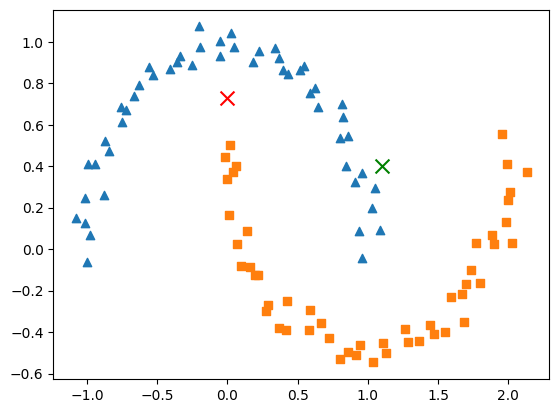

In [3]:
X, y = make_moons(random_state=42, noise=0.05)

markers = ["^", "s"]
for c in np.unique(y):
    mask = y == c
    plt.scatter(X[mask, 0], X[mask, 1], marker=markers[c])

plt.scatter(1.1, 0.4, marker="x", c="green", s=100)
plt.scatter(0.0, 0.73, marker="x", c="red", s=100)

plt.show()

A partir da visualização dos dados e da nossa intuição nós conseguimos pensar em termos de probabilidade: "qual é a maior chance dos pontos demarcados com X serem de uma classe ou outra?"

Implicitamente estamos fazendo isso:

- qual é a chance de X ser triângulo?
- qual é a chance de X ser quadrado?

Nossa resposta é a classe que gerar a maior probabilidade.

### 1.2. Um problema real

<figure>
  <img src="img/a3/tipos-vinho.jpg" width="500px">
  <figcaption>Tipos de vinho. Fonte: <a href="https://mastervinho.com.br/tipos-de-vinho/">Master Vinho</a></figcaption>
</figure>

In [4]:
# Um problema de classificação de tipos de vinho
dataset = load_wine()

# Separa os atributos preditivos e o target (classes)
X, y = dataset.data, dataset.target

print(f"Número de exemplos: {len(X)}")

print("Atributos descritivos:")
for att in dataset.feature_names:
    print(f"-> {att}")

print("\n Tipos de vinho:")
print(dataset.target_names)

Número de exemplos: 178
Atributos descritivos:
-> alcohol
-> malic_acid
-> ash
-> alcalinity_of_ash
-> magnesium
-> total_phenols
-> flavanoids
-> nonflavanoid_phenols
-> proanthocyanins
-> color_intensity
-> hue
-> od280/od315_of_diluted_wines
-> proline

 Tipos de vinho:
['class_0' 'class_1' 'class_2']


E agora? Não dá para fazer um gráfico para nos ajudar. Como lidamos com isso?

...

Hora de retomar o teorema de Bayes e definir o classificador Naive Bayes.

Por que esse algoritmo leva esse nome? 

> Naive = ingênuo

### 1.3. Rapadura é doce, mas não é mole


Na vida real, as evidências normalmente não são independentes. Essas grandezas acontecem de forma conjunta.

**Exemplo:**

> Evento (alvo da classificação): viagem atrasar ou não.

- uma viagem pode atrasar por conta de um pneu furado em um buraco do asfalto

mas


- a chance do motorista não ver o buraco é maior em um dia chuvoso (visibilidade reduzida)
- a velocidade média também (deveria) ser menor no caso de pista molhada

<figure>
  <img src="https://media.istockphoto.com/vectors/office-worker-in-car-vector-id1178291082?k=20&m=1178291082&s=612x612&w=0&h=iIzb4A_uCKbzHLhBjxCXHZaZnavOofbJAP63UJTYMhM=" width="60%">
  <figcaption><a href="https://www.istockphoto.com/br/ilustra%C3%A7%C3%B5es/man-driving-rain">Fonte</a></figcaption>
</figure>


- Se o nosso evento de interesse é "atraso na viagem":
  - As evidências (atributos ou *features*) não são independentes.

- Nesse exemplo, as evidências mencionadas seriam:
  - pneu furou ou não
  - condição climática
  - visibilidade da pista
  - estado de conservação da pista
  - e por aí vai...

- Voltando ao teorema de Bayes:

$$P(A|B) = \dfrac{P(B|A)P(A)}{P(B)}$$

- O que gostaríamos de responder é:
  - $P(\text{Atraso} = \text{sim} | \text{Pneu Furado}, \text{Condição Climática}, ..., )$
  - $P(\text{Atraso} = \text{não} | \text{Pneu Furado}, \text{Condição Climática}, ..., )$
- Observação:
    - É comum utilizar os valores das observações para evitar usar o "=" toda vez.
  - Exemplo: "probabilidade de atrasado, dado que o pneu furou e choveu" $\rightarrow P(\text{atrasado} | \text{pneu-furou}, \text{choveu})$

- Problema: não sabemos responder $P(B|\text{Atraso} = \text{sim})$ e $P(B|\text{Atraso} = \text{não})$
  - As nossas evidências dependem umas das outras.

1. Uma coisa é perguntar (fatos isolados):
  - Qual a chance de um pneu ter furado se a viagem atrasou (ou não)?
  - Qual é probabilidade de estar chovendo (durante o percurso) se a viagem atrasou (ou não)?
  - ...
2. Agora, perguntar (fenômenos simultânemos):
  - Qual é a chance de um pneu ter furado **e** estar chovendo **e** a visibilidade da pista estar ruim **e** a pista estar mal conservada (...) se a viagem atrasou (ou não)?

- A segunda opção parece mais difícil porque realmente é! O nome disso é **probabilidade conjunta** e não é algo fácil de ser calculado, normalmente.


<figure>
  <img src="https://pics.awwmemes.com/al-machine-learning-statistics-if-go-deeper%E2%80%A6-62013620.png" width="40%">
  <figcaption></figcaption>
</figure>


### 1.3. Aplicando o teorema de Bayes concretamente

- Vamos mudar a notação do teorema de Bayes para ficarmos mais próximos de AM.

$$P(c_k | \mathbf{x}) = \dfrac{P(\mathbf{x}|c_k)\times P(c_k)}{P(\mathbf{x})}$$

- $c_k$ representa uma das classes do nosso problema.
  - Ex: Os tipos de vinho no problema anterior, ou se haverá atraso na viagem no exemplo hipotético.
- $\mathbf{x}$ representa as *features* do nosso problema (um vetor/*array*).
  - Cada posição pode ser acessada: $x_i$, assumindo que $i$ varia entre $[0, m - 1]$ e $m$ é o número de *features*.

- Vamos simplificar algo aqui:
  - O denominador será sempre o mesmo, independente da classe.
  - Para aplicar AM nós só queremos saber qual classe tem mais chance de ser a verdadeira. Certo?
  - Então ignoraremos o denominador e vamos assumir que ele é um valor constante comum à todas as classes:

$$P(c_k | \mathbf{x}) = \dfrac{P(\mathbf{x}|c_k)\times P(c_k)}{P(\mathbf{x})} \propto P(\mathbf{x}|c_k)\times P(c_k)$$

- A solução para aplicar o teorema de Bayes em aprendizado de máquina é simplificar o problema.
  - Partimos de uma hipótese bem ingênua:

> Vamos assumir que todas as nossas evidências (*features*) são independentes umas das outras!

- Suposição ousada. Assumir isso significa que para o algoritmo que vamos criar, por exemplo, o fato de estar chovendo não nenhuma relação com a visibilidade da pista. Pode parecer algo meio idiota de se pensar e, de fato, de certa forma é (dado nosso exemplo) :P
- Matematicamente falando:

$$P(x_i | x_0, x_1, ..., x_{i-1}, x_{i + 1}, ..., x_{m - 1}, c_k) = P(x_i | c_k).$$

- Em muitos problemas reais essa simplificação dá conta do recado muito bem!
- **Se as features são independentes**, podemos re-escrever a versão simplificada do teorema de Bayes como:

$$P(c_k | \mathbf{x}) = P(c_k)\prod_{i=0}^{m-1} P(x_i|c_k)$$

#### 1.3.1. Detalhe extra: a transformação log

- Multiplicar vários números (normalmente pequenos) tende a acarretar problemas aproximação numérica.
- Vamos utilizar um "macete" matemático para "escapar" das multiplicações:
  - Aplicar a operação $\log$ em tudo.
- Propriedade: $\log{(a \times b)} = \log{a} + \log{b}$
- Então:

$$\log(P(c_k | \mathbf{x})) = \log(P(c_k)) + \sum_{i=0}^{m-1} \log(P(x_i|c_k))$$

- Para recuperar o valor original, basta aplicar a operação de exponenciação: $v = e^{\log{v}}$.
- Existem várias variações do algoritmo Naive Bayes (NB).
  - Variante voltada para dados numéricos: Gaussian Naive Bayes.

### 1.4. Aproximação com distribuição Gaussiana

<figure>
  <img src="https://pbs.twimg.com/media/EHBVhwDWsAEXeaH.jpg" width="40%">
  <figcaption><a href="https://twitter.com/ai_memes/status/1184540745946017792">Fonte</a></figcaption>
</figure>

Aproxima os valores de $P(x_i | c_k)$ através de distribuições gaussianas ( elas tem propriedades interessantes e modelam muitos fenômenos da vida real). Podemos calcular a probabilidade (função densidade) de um dado valor $x$ em uma distribuição gaussiana através de:

$$f(x) = \dfrac{1}{\sigma\sqrt{2\pi}}e^{-\frac{1}{2}\left(\frac{x - \mu}{\sigma}\right)^2}$$

onde:

- $\mu$: média
- $\sigma$: desvio padrão

<figure>
    <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/7/74/Normal_Distribution_PDF.svg/1200px-Normal_Distribution_PDF.svg.png" width="50%">
    <figcaption>Fonte: <a href="https://pt.wikipedia.org/wiki/Distribui%C3%A7%C3%A3o_normal">Wikipedia</a></figcaption>
</figure>


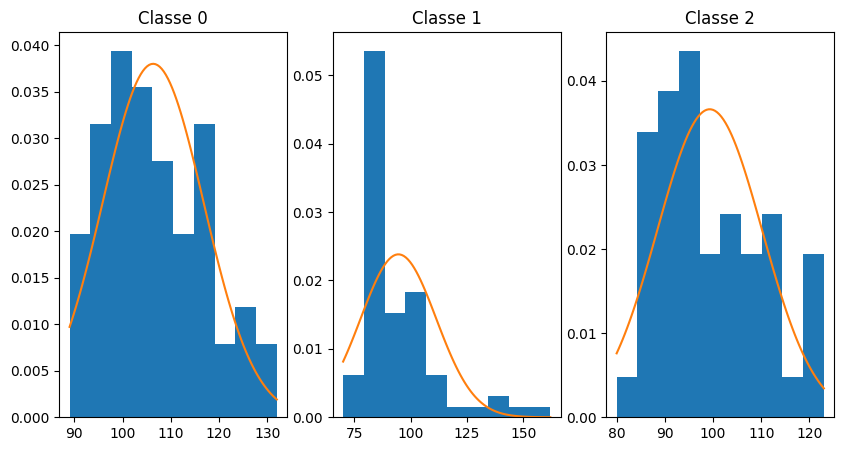

In [5]:
def gaussian_pdf(x, mu, sigma):
    return (
        (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(
            - ((x - mu) ** 2) / (2 * (sigma ** 2))
        )
    )

fig, ax = plt.subplots(figsize=(10, 5), ncols=3)

# Escolhi umas das features arbitrariamente
x_classe_0 = X[y == 0, 4]
x_classe_1 = X[y == 1, 4]
x_classe_2 = X[y == 2, 4]

# Gera histogramas para cada classe
ax[0].hist(x_classe_0, density=True)
ax[1].hist(x_classe_1, density=True)
ax[2].hist(x_classe_2, density=True)

# Define 100 números igualmente espaçados, entre o min e o max
xs_0 = np.linspace(min(x_classe_0), max(x_classe_0), 100)
xs_1 = np.linspace(min(x_classe_1), max(x_classe_1), 100)
xs_2 = np.linspace(min(x_classe_2), max(x_classe_2), 100)

# Exibe os valores das distribuições gaussianas
ax[0].plot(xs_0, gaussian_pdf(xs_0, np.mean(x_classe_0), np.std(x_classe_0, ddof=1)))
ax[1].plot(xs_1, gaussian_pdf(xs_1, np.mean(x_classe_1), np.std(x_classe_1, ddof=1)))
ax[2].plot(xs_2, gaussian_pdf(xs_2, np.mean(x_classe_2), np.std(x_classe_2, ddof=1)))

ax[0].set_title("Classe 0")
ax[1].set_title("Classe 1")
ax[2].set_title("Classe 2")

plt.show()

In [6]:
class GaussianNaiveBayes:
    def fit(self, X, y):
        # Seleciona as classes do problema
        self.classes = np.sort(np.unique(y))
        
        # Já vou salvar o log do nosso conhecimento a priori
        self.logprior = {}
        # Aqui é que entram as gaussianas
        self.likelihood = {}
        # Para cada classe
        for c in self.classes:
            self.likelihood[c] = {}

            class_mask = y == c
            
            # Prior
            self.logprior[c] = np.log(len(y[class_mask]) / len(y))
            
            Mu = np.mean(X[class_mask], axis=0)
            Sigma = np.std(X[class_mask], ddof=1, axis=0)
            
            # Para cada atributo preditivo
            for j in range(X.shape[1]):
                # Guardamos uma função gaussiana do likelihood
                self.likelihood[c][j] = (
                    # Função de densidade de probabilidade da distribuição
                    # Gaussiana
                    lambda x, mu=Mu[j], sigma=Sigma[j] : (
                        (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(
                            - ((x - mu) ** 2) / (2 * (sigma ** 2))
                        )
                    )
                )
    
    def predict_proba(self, X):
        # Numero de amostras x numero de classes
        proba = np.zeros((len(X), len(self.classes)))
        
        for c in self.classes:
            # Adicionamos a probabilidade a priori (estamos utilizando a propriedade aditiva dos logs)
            proba[:, c] += self.logprior[c]
            for j in range(X.shape[1]):
                # Usaremos o log do likelihood
                p = self.likelihood[c][j](X[:, j])
                # Valores muito proximos de zero podem nos dar problema
                # Melhor evitá-los (considerar como zero, logo de uma vez)
                mask = p > 0
                # Usa a máscara binária criada para filtrar os valores
                proba[mask, c] += np.log(p[mask])
        
        # Aplicamos a funçao exponencial para desfazer o efeito do log
        proba = np.exp(proba)
        
        # Função Softmax para obtermos uma distribuição de probabilidade.
        # Lembre-se que nós removemos o P(x) do denominador da equação de Bayes
        # para simplificar os calculos. Precisamos normalizar os valores para
        # obter probabilidades
        exp_proba = np.exp(proba)
        proba = exp_proba / np.sum(exp_proba, axis=1)[:, None]

        return proba

    def predict(self, X):
        # Retorna a classe mais provavel
        return self.classes[np.argmax(self.predict_proba(X), axis=1)]


## 2. Exemplo com processamento de texto